# Analysis: Identify Large Prediction Shifts

This is a sandbox notebook for exploring a proof of concept for highlighting large shifts in predictions. The goals are:
- Identify time frames in the game where large shifts in win probability happen
- Use SHAP model analysis to highlight which features caused the shift in predictions

## Setup

In [1]:
%%capture
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import starcraft_predictor as scp
import shap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
import seaborn as sns

## Load Replay

In [3]:
# load the example replay
replay = scp.api._load_replay("../example_data/example_replay.SC2Replay")

# process the replay into a dataframe
processed_replay = scp.api._process_replay(replay)

# generate predictions for the replay
predictions = scp.api._generate_predictions(processed_replay)

In [4]:
def get_local_min_max_values(predictions: list) -> list:
    """Iteratively go through a list and
    identify all the local maxima and local minima,
    then return the index of all those points.
    
    eg: given predictions = [1, 3, 5, 3, 2, 8]
    
    The function would return: [0, 2, 4, 5]
    
    """
    
    min_max_points = []
    direction = ""
    for i, pred in enumerate(predictions):
        
        # append the first value as a local maxima/minima
        if i == 0:
            pred_value = pred
            min_max_points.append(0)
        
        # determine the direction at the start
        if i == 1:
            if pred < pred_value:
                direction = "down"
                pred_value = pred
            else:
                direction = "up"
                pred_value = pred
        # iterate through all points, taking note of when
        # direction changes (ie, local maxima/minima)
        else:
            if direction == "down":
                if pred < pred_value:
                    pred_value = pred
                else:
                    min_max_points.append(i-1)
                    direction = "up"
                    pred_value = pred
            elif direction == "up":
                if pred > pred_value:
                    pred_value = pred
                else:
                    min_max_points.append(i-1)
                    direction = "down"
                    pred_value = pred

    min_max_points.append(i)
    
    return min_max_points

In [5]:
def get_differences(predictions, min_max_points):
    """For each pair of local min/max, calculate the
    prediction difference between them.
    
    """
    
    differences = []
    
    for i in range(len(min_max_points) - 1):
        
        differences.append(predictions[min_max_points[i + 1]] - predictions[min_max_points[i]])
    
    return differences

In [6]:
def get_top_three_differences(differences):
    """Get the largest 3 prediction shifts, and the pair it
    with the index of the first point in that shift (note, each
    shift has two points, a max and min).
    
    """
    
    abs_differences = [abs(x) for x in differences]
    
    top_three_shifts = sorted(zip(abs_differences, range(len(differences))), reverse=True)[:3]
    
    return top_three_shifts

In [7]:
def get_value_indexes(min_max_values, difference_index):
    """From the min/max index associated with the large shift, get
    the prediction index.
    
    """
    
    return (min_max_values[difference_index], min_max_values[difference_index + 1])

In [8]:
# note: there are lots of fluctuations at the start, hence many consecutive min/max points
min_max_points = get_local_min_max_values(predictions)
min_max_points[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 22]

In [9]:
# note: the differences should alternative between + and -
differences = get_differences(predictions, min_max_points)
differences[10:20]

[0.016330231387250482,
 -0.008165614083156691,
 0.006803390938168841,
 -0.007484118319714073,
 0.0071436015072812165,
 -0.00731377361474711,
 0.0045429160356502685,
 -0.00889247962831441,
 0.01142015791566342,
 -0.0037130362195095246]

In [10]:
top_three_shifts = get_top_three_differences(differences)
top_three_shifts

[(0.4499071829265089, 32), (0.3998659456010938, 42), (0.253538651907936, 39)]

In [11]:
replay_indexes = [get_value_indexes(min_max_points, x[1]) for x in top_three_shifts]
replay_indexes

[(70, 84), (120, 145), (114, 117)]

In [12]:
def get_prediction_change_indexes(predictions):
    """Wrapper for functions above"""
    
    min_max_points = get_local_min_max_values(predictions)
    differences = get_differences(predictions, min_max_points)
    top_three_shifts = get_top_three_differences(differences)
    replay_indexes = [get_value_indexes(min_max_points, x[1]) for x in top_three_shifts]
    
    return replay_indexes

In [13]:
get_prediction_change_indexes(predictions)

[(70, 84), (120, 145), (114, 117)]

The `replay_indexes` shown above represent pairs of points in the game where the prediction probabilities shift the most, where index=0 is the start of the game. To break this down further:

The index pair (70, 84) represents game times 11:30 and 13:50. The model indicates there is a big shift in win probabilty between these two times.

## SHAP Analysis

In [14]:
# Extract XGBoost model and FEATURES list from scp package
pre_trained_model = scp.api.model.model
FEATURES = scp.modelling.model_params.FEATURES

In [15]:
# generate shap values for the processed replay
explainer = shap.TreeExplainer(pre_trained_model)
shap_values = explainer.shap_values(processed_replay[FEATURES])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [16]:
def plot_shap_differences(shap_values, features, index_pair):
    
    # generate plotting dataframe
    plotting_dataframe = pd.DataFrame({
        "features": features,
        "first_index": shap_values[index_pair[0]],
        "second_index": shap_values[index_pair[1]],
        "abs_difference": abs(shap_values[index_pair[0]] - shap_values[index_pair[1]])
    })
    
    plotting_dataframe.sort_values("abs_difference", ascending=False, inplace=True)
    plotting_dataframe.reset_index(inplace=True, drop=True)
    
    # plot the feature contribution for each index
    fig, ax = plt.subplots(figsize=(40,15))

    sns.barplot(
        y=plotting_dataframe["features"],
        x=plotting_dataframe["first_index"],
        color="blue",
        alpha=0.5,
        label="first_index",
    )
    sns.barplot(
        y=plotting_dataframe["features"],
        x=plotting_dataframe["second_index"],
        color="red",
        alpha=0.5,
        label="second_index",
    )
    
    plt.xlabel("prediction contribution")

    plt.legend()
    plt.show()

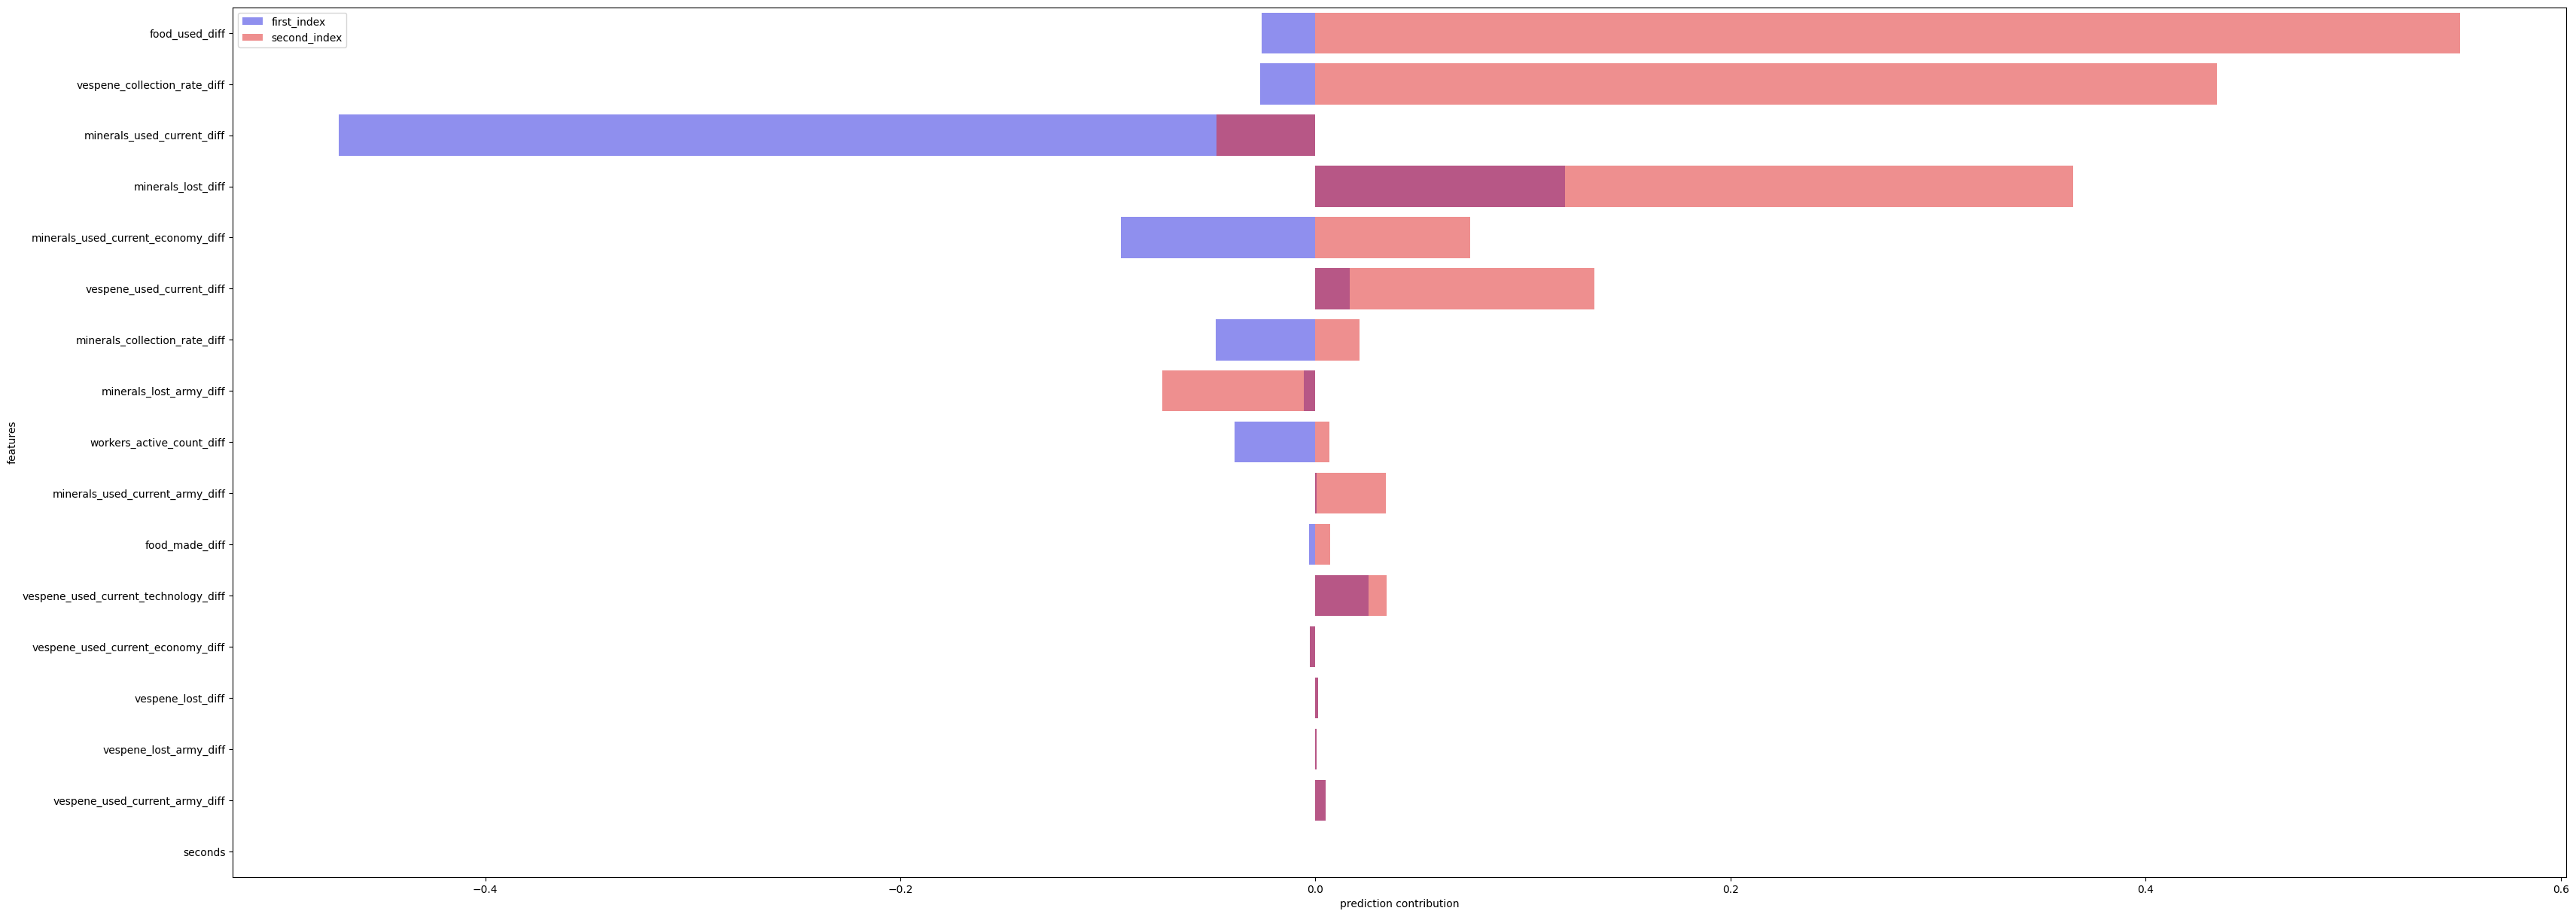

In [17]:
plot_shap_differences(shap_values, FEATURES, replay_indexes[0])

## Plot Explained

The plot shows the feature contribution for the prediction at the first index (blue), and the second index (red). A bar to the left of zero indicates that feature is reducing the prediction, and a bar to the right of zero indicates that feature is increasing the prediction. A big change is indicated by the size gap between the end of the blue bar and the end of the red bar. The features are ordered from top to bottom, starting with the feature that has changed the prediction the most.

Some example insights can we take-away from reading the plot above:
- The feature causing the biggest change in prediction between 11:30 (index 70) and 13:50 (index 84) is `food_used_diff`
- `food_used_diff` reduces the probabiltiy prediction by a small amount for the first index, indicated by a small blue bar to the left.
- `food_used_diff` increased the probabiltiy prediction by a large amount for the second index, indicated by a large red line to the right.
- `minerals_used_current_diff` reduces the probability prediction by a large amount for the first index, indicated by a large blue line to the left.
- `minerals_used_current_diff` reduces the probability prediction by a small amount for the second index, indicated by a small red line to the left.

This gives us direction for what to look at in the data, now we can actually examine these differences!

In [18]:
print(processed_replay.loc[replay_indexes[0][0], "food_used_diff"])
print(processed_replay.loc[replay_indexes[0][1], "food_used_diff"])

-2.0
-33.0


A shift in 31 supply is the main driver for why probability predictions shifted so much.

## Identify the driving feature for point change point in the replay

In [19]:
def get_change_in_feature(shap_values, features, processed_replay, index_pair):
    """Extract the main driving feature, and the change in that feature, for a given
    index pair.

    """
    
    # get SHAP values for the first and second index
    first_index_values = shap_values[index_pair[0]]
    second_index_values = shap_values[index_pair[1]]
    
    # get the absolute difference in feature SHAP contribution between the two indexes
    abs_difference = abs(shap_values[index_pair[0]] - shap_values[index_pair[1]])

    # find the feature with the largest SHAP contribution difference
    index_of_max_diff = np.where(abs_difference == abs_difference.max())[0][0]
    feature = features[index_of_max_diff]

    # find the value of that feature for the first and second index from the replay
    first_feature_value = processed_replay.loc[index_pair[0], feature]
    second_feature_value = processed_replay.loc[index_pair[1], feature]

    # calculate how much that feature changed from the first to the second index point
    feature_change = abs(second_feature_value - first_feature_value)

    return index_pair, feature, feature_change

In [20]:
feature_change = get_change_in_feature(shap_values, FEATURES, processed_replay, replay_indexes[0])
feature_change

((70, 84), 'food_used_diff', 31.0)

In [21]:
def identify_prediction_shifts(processed_replay, predictions):
    
    # get indexes for the top 3 periods where predictions change the most
    pred_change_indexes = get_prediction_change_indexes(predictions)
    
    # generate SHAP values
    explainer = shap.TreeExplainer(scp.starcraft_model.model)
    shap_values = explainer.shap_values(processed_replay[scp.modelling.model_params.FEATURES])
    
    feature_changes = []
    
    # for each of the 3 index pairs, calculate the driving feature, and the change in that feature
    for index_pair in pred_change_indexes:
        feature_changes.append(get_change_in_feature(
            shap_values,
            scp.modelling.model_params.FEATURES,
            processed_replay,
            index_pair,
        ))
    
    return feature_changes

In [22]:
feature_changes = identify_prediction_shifts(processed_replay, predictions)
feature_changes

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[((70, 84), 'food_used_diff', 31.0),
 ((120, 145), 'minerals_used_current_diff', 7850.0),
 ((114, 117), 'minerals_used_current_diff', 1850.0)]

## Plot Modification

In [23]:
# use the same plot_params method that is currently implemented since
# all the same information is needed.
plot_params = scp.api._get_plot_params(processed_replay, predictions)

In [24]:
# update so both races arent the same, this allows testing of colour changes in plot
plot_params["p1_race"] = "z"

In [25]:
def threshold_plot(ax, x, y, threshv, color, overcolor):
    """
    Helper function to plot points above a threshold in a different color.

    This is a pretty hacky way to assign the colours with if/elif statements. Should
    find a way to make this less verbose.

    Parameters
    ----------
    ax : Axes
        Axes to plot to
    x, y : array
        The x and y values

    threshv : float
        Plot using overcolor above this value

    color : color
        The color to use for the lower values

    overcolor: color
        The color to use for values over threshv

    """
   
    # splits x and y into individual line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # for each line segment, assess what colour it should be
    for i, segment in enumerate(segments):
        if segment[:, 1][0] < 0.5:
            plot_color = color
        elif segment[:, 1][0] > 0.5:
            plot_color = overcolor
        elif segment[:, 1][1] < 0.5:
            plot_color = color
        else:
            plot_color = overcolor

        # plot that individual line segment
        ax.plot(segment[:, 0], segment[:, 1], color=plot_color, linewidth=5)

In [26]:
def win_probability_plot(plot_params, moment=None):
    
    # set global setting for background
    plt.rcParams['font.family'] = 'monospace'
    prop = font_manager.FontProperties(fname="Starcraft Normal.ttf")
    colour_map = {
        "z": "purple",
        "p": "blue",
        "t": "red",
    }

    # create fig and axis
    fig, ax = plt.subplots(figsize=(20, 10), facecolor="#00182c")

    # set facecolor
    ax.set_facecolor("#010713")

    # plot the win probability line
    threshold_plot(
        ax,
        plot_params["df"]["seconds"],
        plot_params["df"]["win_prob"],
        .5,
        colour_map[plot_params["p1_race"]],
        colour_map[plot_params["p2_race"]],
    )

    # plot 50% line
    sns.lineplot(x=plot_params["df"]["seconds"], y=0.5, color="white", ls="dashed", lw=0.5)

    # set ticks and tick parameters (font, color, etc.)
    ax.set_xticks(plot_params["df"]["seconds"].values[::6])
    ax.set_xticklabels([int(val) for val in plot_params["df"]["seconds"].values[::6] / 60])
    ax.tick_params(axis='x', colors='#62afd4', labelsize=15)
    ax.tick_params(axis='y', colors='#62afd4', labelsize=15)

    # set x and y axis limits
    ax.set_ylim(0, 1)
    ax.set_xlim(plot_params["df"]["seconds"].values[0], plot_params["df"]["seconds"].values[-1])

    # copy axis to have a separate set of x ticks on the top of the plot
    ax2 = ax.twiny()

    if moment:
        ax2.xaxis.tick_top()   
        ax2.xaxis.set_label_position('top') 

        # set x limit of top axis to match the bottom axis
        ax2.set_xlim(plot_params["df"]["seconds"].values[0], plot_params["df"]["seconds"].values[-1])

        # set tick and tick_label for important game moment
        ax2.set_xticks([(moment[0][0] + moment[0][1])*5])
        ax2.set_xticklabels([f"{moment[1]}: {moment[2]}"])
        ax2.tick_params(axis='x', colors='#62afd4', labelsize=15)

        # plot 'red zone' for important game moment
        sns.lineplot(x=moment[0][0]*10, y=[0, 1], color="red")
        sns.lineplot(x=moment[0][1]*10, y=[0, 1], color="red")
        ax2.fill_between(x=[moment[0][0]*10, moment[0][1]*10], y1=[1], color='red', alpha=0.1)
                   
        ax2.spines['bottom'].set_color('#62afd4')
        ax2.spines['top'].set_color('#62afd4')
        ax2.spines['left'].set_color('#62afd4')
        ax2.spines['right'].set_color('#62afd4')

    # add custom legend with player colours
    patch_1 = mpatches.Patch(color=colour_map[plot_params["p1_race"]], label='Player 1')
    patch_2 = mpatches.Patch(color=colour_map[plot_params["p2_race"]], label='Player 2')
    plt.legend(
        handles=[patch_1, patch_2],
        loc="upper left",
        facecolor="#00182c",
        labelcolor="#62afd4",
    )

    # add title and labels to plots
    plt.title(f"Win Probability Plot\n", color="#62afd4", fontsize=30, fontproperties=prop)
    ax.set_ylabel("Win Probability\n", fontsize=20, color="#62afd4")
    ax.set_xlabel("\nMinutes", fontsize=20, color="#62afd4")
    plt.tight_layout()

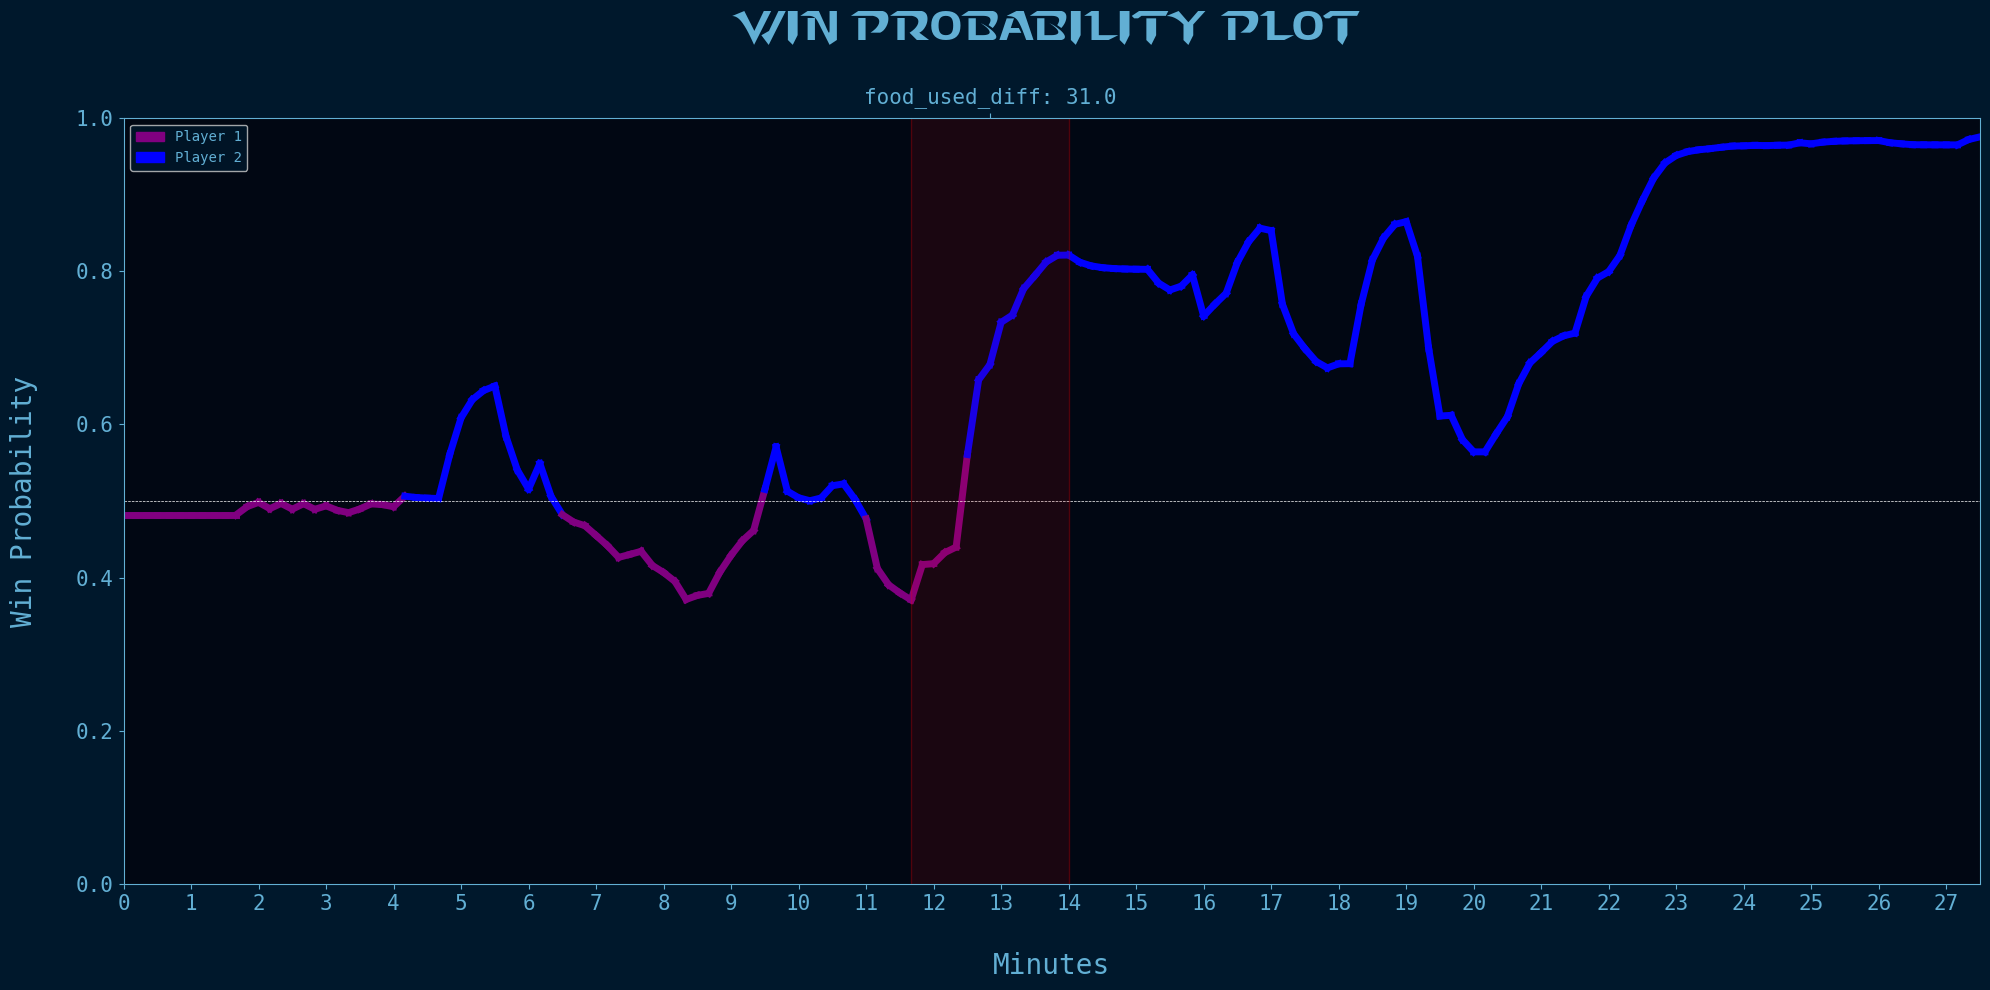

In [27]:
win_probability_plot(plot_params, moment=feature_changes[0])

## Making the lines change colour exactly on the threshold (0.5)

In [28]:
def find_crossing_pairs(y, threshold):
    """Function to find the pair of y values that cross a given threshold"""

    pairs = []
    
    y_temp = list(np.subtract(y, threshold))
    
    for i in range(len(y_temp) - 1):
        if np.sign(y_temp[i]) == 0:
            pass
        elif np.sign(y_temp[i]) != np.sign(y_temp[i + 1]):
            pairs.append((i, i+1))
            
    return pairs

In [29]:
def insert_new_values(x, y, crossing_index, threshold):
    """Function to insert a new value inbetween the crossing pair, that sits
    on the threshold line.
    
    """

    rate_of_change = (y[crossing_index[1]] - y[crossing_index[0]]) / (x[crossing_index[1]] - x[crossing_index[0]])

    x_movement = (threshold - y[crossing_index[0]]) / rate_of_change

    new_x = x[crossing_index[0]] + x_movement
    
    x.insert(crossing_index[1], new_x)
    y.insert(crossing_index[1], 0.5)

    return x, y

In [30]:
def add_zero_points(x, y, threshold):
    """Wrapper to apply the insert_new_values function to
    all crosisng pairs in x and y

    """
    
    crossing_pairs = find_crossing_pairs(y, threshold)
    
    for i, pair in enumerate(crossing_pairs):

        pair = tuple(np.add(pair, i))
        x, y, = insert_new_values(x, y, pair, threshold)
    
    return x, y

In [31]:
# update x and y with above functions, and re-define plot_params ready for plotting
x = list(plot_params["df"]["seconds"].values)
y = list(plot_params["df"]["win_prob"].values)

x, y = add_zero_points(x, y, 0.5)

plot_params["df"] = pd.DataFrame({"seconds": x, "win_prob": y})

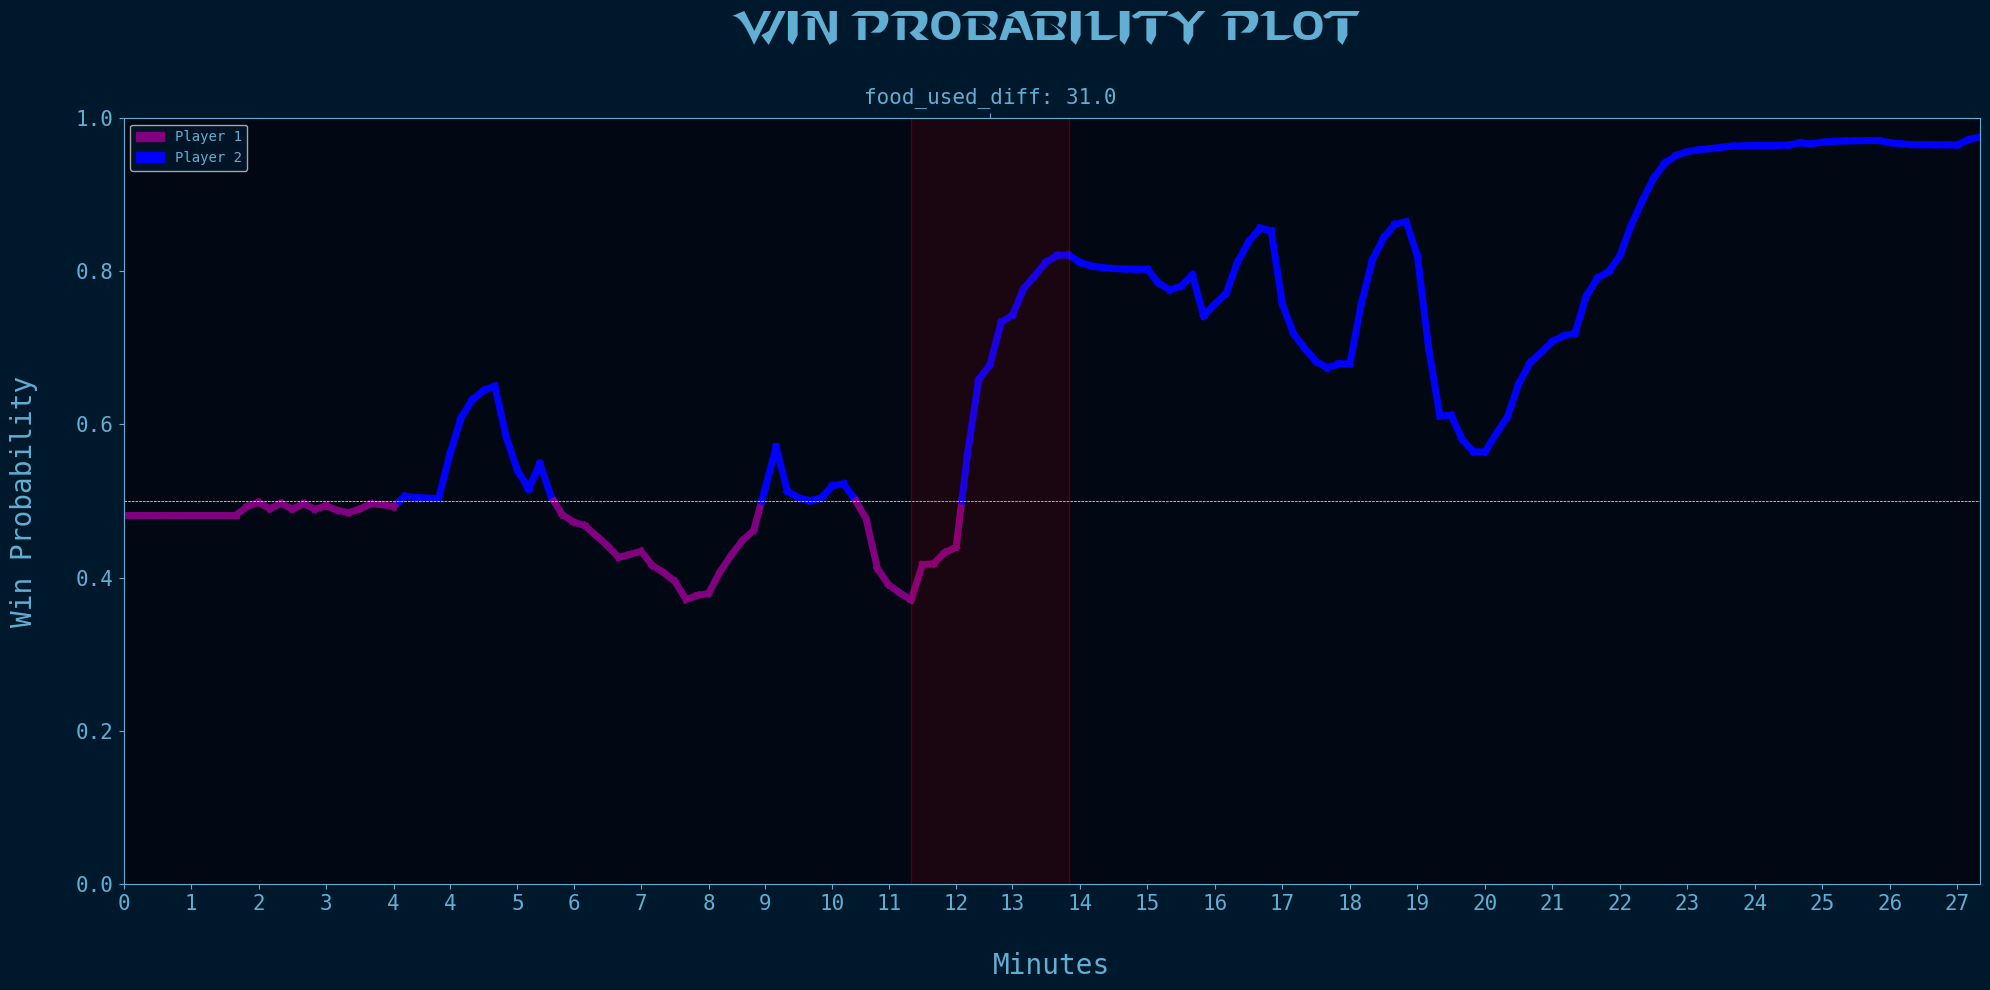

In [32]:
win_probability_plot(plot_params, moment=feature_changes[0])

The line now changes colour exactly at the threshold!